# Implementation of AutoEncoder (AE) (New latent vec for customers)


## AE

- no assumption at latent vec distribution
- bias on latent vec rather than generative ability

python and pytorch version: python=3.7, pytorch=1.3.1

In [1]:
import torch
import torch.nn as nn
import numpy as np
import torchvision.transforms as transforms

from torch.optim import Adam
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torch.utils.data.sampler import SubsetRandomSampler
from sklearn.metrics.cluster import normalized_mutual_info_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn import mixture
from matplotlib import pyplot as plt
from matplotlib.patches import Ellipse

'''
A clustering result satisfies completeness,
if all the data points that are members of a given class are elements of the same cluster.
'''
from sklearn.metrics.cluster import completeness_score


# Model Hyperparameters

In [2]:
# Model Hyperparameters

dataset_path = './'
model_name = 'MNIST_VAE_256_64_latent'

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")


batch_size = 100

x_dim  = 784
hidden_dim = 256
latent_dim = 64

lr = 1e-3

epochs = 30

###    Step 1. Load (or download) Dataset

In [3]:
def partition_dataset(n, proportion=0.8):
  train_num = int(n * proportion)
  indices = np.random.permutation(n)
  train_indices, val_indices = indices[:train_num], indices[train_num:]
  return train_indices, val_indices
mnist_transform = transforms.Compose([
        transforms.ToTensor(),
])

kwargs = {'num_workers': 1, 'pin_memory': True} 

train_dataset = MNIST(dataset_path, transform=mnist_transform, train=True, download=True)
test_dataset  = MNIST(dataset_path, transform=mnist_transform, train=False, download=True)

train_proportion = 0.8
# partition dataset according to train_proportion
train_indices, val_indices = partition_dataset(len(train_dataset), train_proportion)
# create data loaders for train, validation and test datasets
train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(train_indices))
val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=SubsetRandomSampler(val_indices))

test_loader  = DataLoader(dataset=test_dataset,  batch_size=batch_size, shuffle=False, **kwargs)

C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\torchvision\datasets\mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  ..\torch\csrc\utils\tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### Step 2. Define our model: AutoEncoder (AE)

In [4]:
"""
    A simple implementation of MLP Encoder and Decoder
"""

class Encoder(nn.Module):
    
    def __init__(self, input_dim, hidden_dim, latent_dim):
        super(Encoder, self).__init__()

        self.FC_input1 = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_mean  = nn.Linear(hidden_dim, latent_dim)
        self.FC_var   = nn.Linear (hidden_dim, latent_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
        self.training = True
        
    def forward(self, x):
        h_       = self.FC_input1(x)
        h_       = self.LeakyReLU(h_)

        h_       = self.FC_input2(h_)
        h_       = self.LeakyReLU(h_)

        mean     = self.FC_mean(h_)
        log_var  = self.FC_var(h_)                     # encoder produces mean and log of variance 
                                                       #             (i.e., parateters of simple tractable normal distribution "q"
        return mean, log_var                   

In [5]:
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim, output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden1 = nn.Linear(latent_dim, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)
        
        self.LeakyReLU = nn.LeakyReLU(0.2)
        
    def forward(self, x):
        h     = self.FC_hidden1(x)
        h     = self.LeakyReLU(h)

        h     = self.FC_hidden2(h)
        h     = self.LeakyReLU(h)
        
        x_hat = torch.sigmoid(self.FC_output(h))
        return x_hat
        

In [6]:
class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean, var):
        epsilon = torch.randn_like(var).to(DEVICE)        # sampling epsilon        
        z = mean + var*epsilon                          # reparameterization trick
        return z
        
                
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var)
        x_hat = self.Decoder(z)
        
        return x_hat, z, mean, log_var

In [7]:
encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim=hidden_dim, output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)
print(model)

Model(
  (Encoder): Encoder(
    (FC_input1): Linear(in_features=784, out_features=256, bias=True)
    (FC_input2): Linear(in_features=256, out_features=256, bias=True)
    (FC_mean): Linear(in_features=256, out_features=64, bias=True)
    (FC_var): Linear(in_features=256, out_features=64, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
  (Decoder): Decoder(
    (FC_hidden1): Linear(in_features=64, out_features=256, bias=True)
    (FC_hidden2): Linear(in_features=256, out_features=256, bias=True)
    (FC_output): Linear(in_features=256, out_features=784, bias=True)
    (LeakyReLU): LeakyReLU(negative_slope=0.2)
  )
)


### Step 3. Define Loss function (reprod. loss) and optimizer

In [8]:
def loss_function(x, x_hat, mean, log_var):
    reproduction_loss = nn.functional.binary_cross_entropy(x_hat, x, reduction='sum')
    KLD = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())

    return reproduction_loss + KLD

optimizer = Adam(model.parameters(), lr=lr)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5, threshold= 0.1)

### Step 4. Train & val  

In [9]:
print("Start training VAE...")
model.train()

training_losses = []
val_losses = []
lrs = []

for epoch in range(epochs):
    training_loss = 0
    val_loss = 0

    # training
    for batch_idx, (x, _) in enumerate(train_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, z, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        training_loss += loss.item()       

        loss.backward()
        optimizer.step()

    average_training_loss = training_loss/len(train_dataset)
    training_losses.append(average_training_loss)

    # validation
    for batch_idx, (x, _) in enumerate(val_loader):
        x = x.view(batch_size, x_dim)
        x = x.to(DEVICE)

        optimizer.zero_grad()

        x_hat, z, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean, log_var)
        
        val_loss += loss.item()

    average_val_loss = val_loss/len(test_dataset)
    val_losses.append(average_val_loss)

    scheduler.step(val_loss)    
    lrs.append(scheduler._last_lr[0])

    print("\tEpoch", epoch + 1, "complete!", "\tAverage Train Loss: ", average_training_loss, "\tAverage Val Loss: ", average_val_loss)

torch.save({ 
    'model_state_dict': model.state_dict(), 
    'optimizer_state_dict': optimizer.state_dict(), 
    'scheduler_state_dict': scheduler.state_dict(),
    }, './models/'+model_name+'.pth') 

print("Finish!!")

Start training VAE...
	Epoch 1 complete! 	Average Train Loss:  148.062080859375 	Average Val Loss:  180.3043130859375
	Epoch 2 complete! 	Average Train Loss:  108.43131993815105 	Average Val Loss:  151.263725
	Epoch 3 complete! 	Average Train Loss:  97.6023966796875 	Average Val Loss:  142.87729013671876
	Epoch 4 complete! 	Average Train Loss:  93.46826790364584 	Average Val Loss:  137.93016416015624
	Epoch 5 complete! 	Average Train Loss:  90.89905849609374 	Average Val Loss:  134.52437646484375
	Epoch 6 complete! 	Average Train Loss:  89.03739318033854 	Average Val Loss:  132.6386025390625
	Epoch 7 complete! 	Average Train Loss:  87.75284295247396 	Average Val Loss:  130.97436201171874
	Epoch 8 complete! 	Average Train Loss:  86.80515838216145 	Average Val Loss:  129.87459208984376
	Epoch 9 complete! 	Average Train Loss:  86.00622425130209 	Average Val Loss:  128.751348046875
	Epoch 10 complete! 	Average Train Loss:  84.4217139811198 	Average Val Loss:  126.77271923828125
	Epoch 11 c

### Plot loss over epoch - Latent_dim=2

Text(0, 0.5, 'Loss')

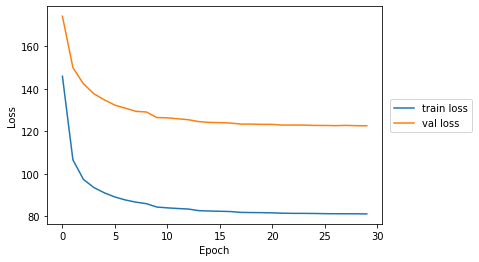

In [ ]:
ax, fig = plt.subplots()
plt.plot(training_losses)
plt.plot(val_losses)
ax.legend(['train loss', 'val loss'], bbox_to_anchor=(1.12,0.5), loc="center right",)
plt.xlabel('Epoch')
plt.ylabel('Loss')

Text(0, 0.5, 'LR')

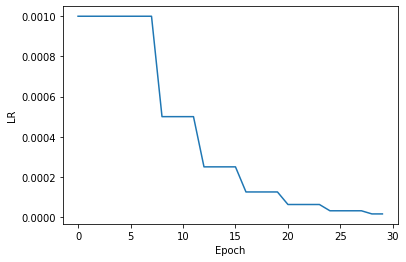

In [ ]:
plt.plot(lrs)
plt.xlabel('Epoch')
plt.ylabel('LR')

## Step 5. Generate images from test dataset

In [11]:
# Load models
# 8 Latent Dimension
encoder8 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=8)
decoder8 = Decoder(latent_dim=8, hidden_dim=hidden_dim, output_dim = x_dim)
model8 = Model(Encoder=encoder8, Decoder=decoder8).to(DEVICE)
optimizer8 = Adam(model8.parameters(), lr=lr)
scheduler8 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer8, 'min', patience=3, factor=0.5, threshold= 0.1)

checkpoint8 = torch.load('./models/MNIST_VAE_256_8_latent.pth')
model8.load_state_dict(checkpoint8['model_state_dict'])
optimizer8.load_state_dict(checkpoint8['optimizer_state_dict'])
scheduler8.load_state_dict(checkpoint8['scheduler_state_dict'])

# 10 Latent Dimension
encoder10 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=10)
decoder10 = Decoder(latent_dim=10, hidden_dim=hidden_dim, output_dim = x_dim)
model10 = Model(Encoder=encoder10, Decoder=decoder10).to(DEVICE)
optimizer10 = Adam(model10.parameters(), lr=lr)
scheduler10 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer10, 'min', patience=3, factor=0.5, threshold= 0.1)

checkpoint10 = torch.load('./models/MNIST_VAE_256_10_latent.pth')
model10.load_state_dict(checkpoint10['model_state_dict'])
optimizer10.load_state_dict(checkpoint10['optimizer_state_dict'])
scheduler10.load_state_dict(checkpoint10['scheduler_state_dict'])

# 16 Latent Dimension
encoder16 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=16)
decoder16 = Decoder(latent_dim=16, hidden_dim=hidden_dim, output_dim = x_dim)
model16 = Model(Encoder=encoder16, Decoder=decoder16).to(DEVICE)
optimizer16 = Adam(model16.parameters(), lr=lr)
scheduler16 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer16, 'min', patience=3, factor=0.5, threshold= 0.1)

checkpoint16 = torch.load('./models/MNIST_VAE_256_16_latent.pth')
model16.load_state_dict(checkpoint16['model_state_dict'])
optimizer16.load_state_dict(checkpoint16['optimizer_state_dict'])
scheduler16.load_state_dict(checkpoint16['scheduler_state_dict'])

# 64 Latent Dimension
encoder64 = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, latent_dim=64)
decoder64 = Decoder(latent_dim=64, hidden_dim=hidden_dim, output_dim = x_dim)
model64 = Model(Encoder=encoder64, Decoder=decoder64).to(DEVICE)
optimizer64 = Adam(model64.parameters(), lr=lr)
scheduler64 = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer64, 'min', patience=3, factor=0.5, threshold= 0.1)

checkpoint64 = torch.load('./models/MNIST_VAE_256_64_latent.pth')
model64.load_state_dict(checkpoint64['model_state_dict'])
optimizer64.load_state_dict(checkpoint64['optimizer_state_dict'])
scheduler64.load_state_dict(checkpoint64['scheduler_state_dict'])

In [12]:
# Get features and true labels
def test_model(model, test_loader, latent_dim):
    model8.eval()
    start_ind = 0
    n = len(test_loader.dataset)
    true_labels = np.zeros(n, dtype=np.int64)
    features = np.zeros((n, latent_dim))
    with torch.no_grad():
        for (x, y) in test_loader:
            # flatten data
            x = x.view(x.size(0), -1)  
            x_hat, z, mean, log_var = model(x)
            end_ind = min(start_ind + x.size(0), n+1)

            true_labels[start_ind:end_ind] = y
            features[start_ind:end_ind] = mean
            start_ind += x.size(0)
    return true_labels, x_hat, features

true_labels, x_hat8, features8 = test_model(model8, test_loader, 8)
true_labels, x_hat10, features10 = test_model(model10, test_loader, 10)
true_labels, x_hat16, features16 = test_model(model16, test_loader, 16)
true_labels, x_hat64, features64 = test_model(model64, test_loader, 64)

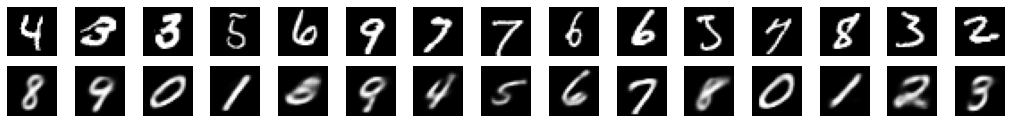

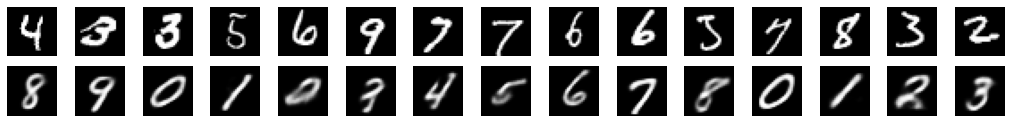

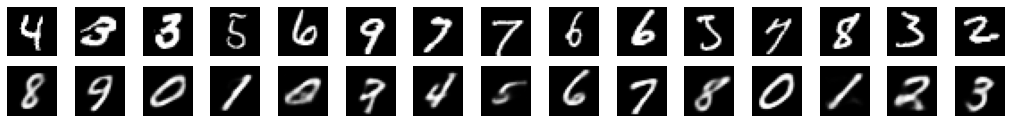

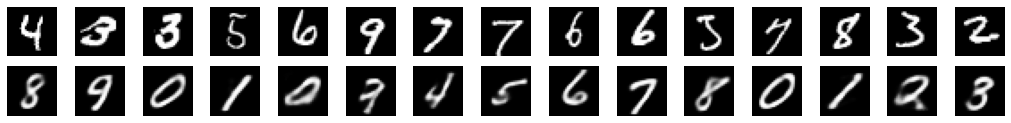

In [13]:
# Compare reconstructed images with original images
def display_reconstructed(original, reconstructed, n, name):
  plt.figure(figsize=[18,2])
  for i in range(n):
    plt.subplot(2, n, i + 1)
    plt.imshow(original[i].reshape(28, 28))
    plt.gray()
    plt.axis('off')
    
    if reconstructed is not None:
      plt.subplot(2, n, i + n + 1)
      plt.imshow(reconstructed[i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.savefig('./figures/'+name+'.png')
  plt.show()

number = 15
display_reconstructed(x[:number], x_hat8[:number], number, 'compare_256_8')
display_reconstructed(x[:number], x_hat10[:number], number, 'compare_256_10')
display_reconstructed(x[:number], x_hat16[:number], number, 'compare_256_16')
display_reconstructed(x[:number], x_hat64[:number], number, 'compare_256_64')

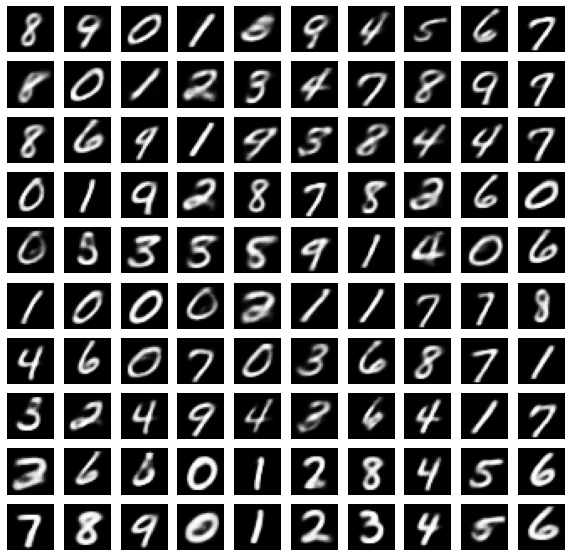

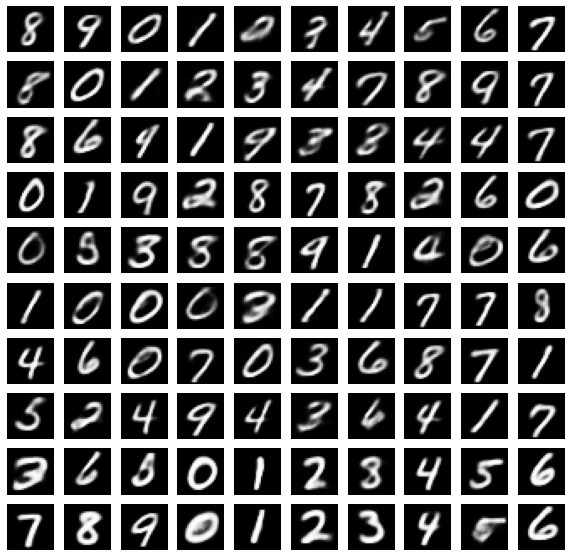

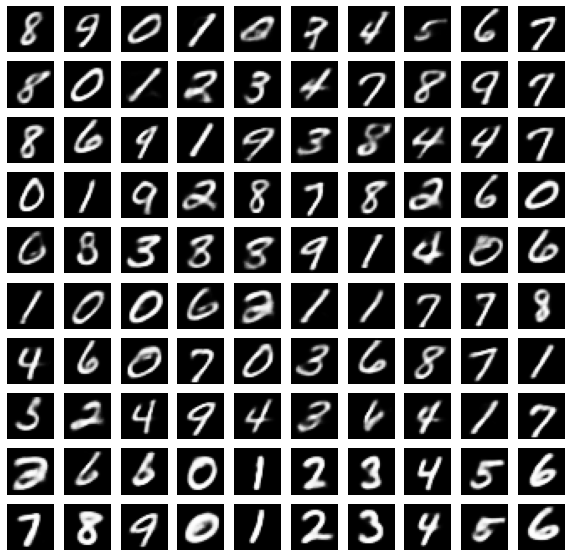

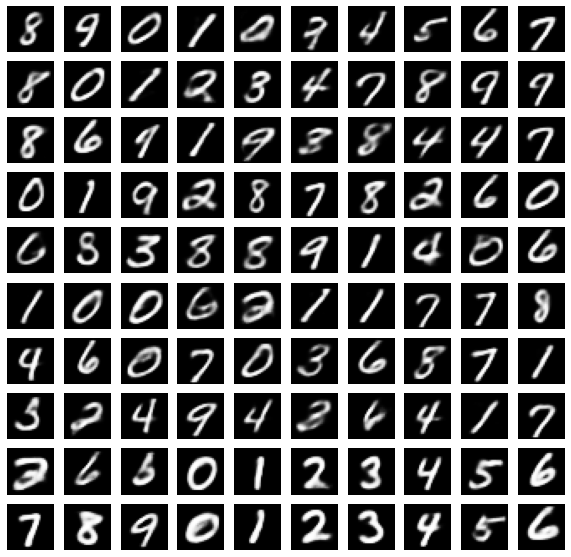

In [14]:
def display_random_generation(generated, num_classes, n, name):
  plt.figure(figsize=[10,10])
  for c in range(num_classes):
    for i in range(n):
      plt.subplot(num_classes, n, (c * n) + i + 1)
      plt.imshow(generated[(c * n) + i].reshape(28, 28))
      plt.gray()
      plt.axis('off')
  plt.savefig('./figures/'+name+'.png')
  plt.show()

elem_per_category = 10
num_classes = 10

display_random_generation(x_hat8, num_classes, elem_per_category, 'reconstruction_256_8')
display_random_generation(x_hat10, num_classes, elem_per_category, 'reconstruction_256_10')
display_random_generation(x_hat16, num_classes, elem_per_category, 'reconstruction_256_16')
display_random_generation(x_hat64, num_classes, elem_per_category, 'reconstruction_256_64')

## Step 6. Plot latent features with true labels

In [15]:
# reduce dimensionality to 2D, we consider a subset of data because TSNE is a slow algorithm
tsne_features8 = TSNE(n_components=2).fit_transform(features8)
tsne_features10 = TSNE(n_components=2).fit_transform(features10)
tsne_features16 = TSNE(n_components=2).fit_transform(features16)
tsne_features64 = TSNE(n_components=2).fit_transform(features64)

C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default

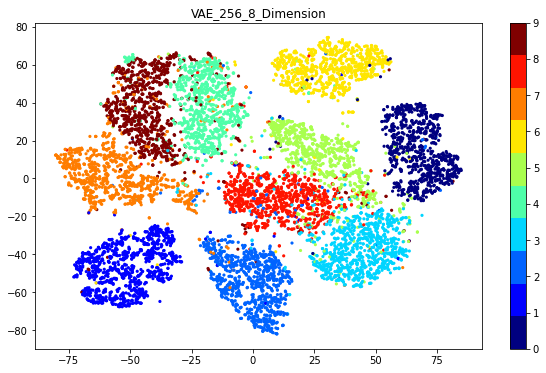

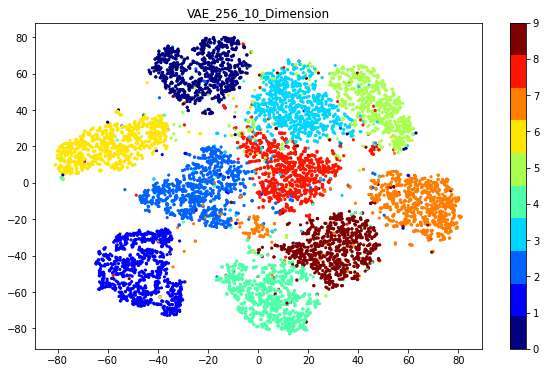

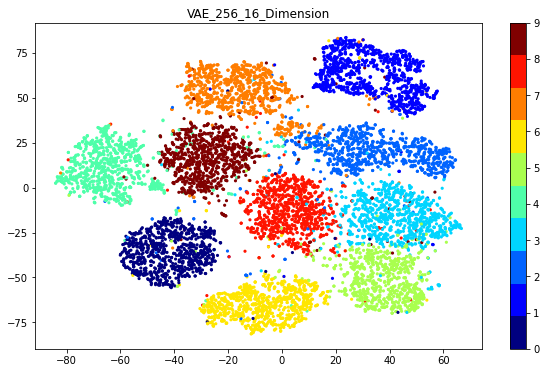

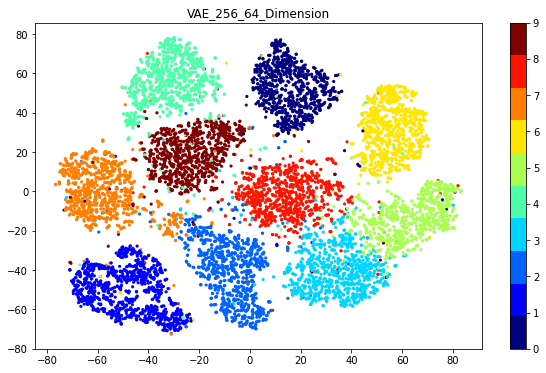

In [16]:
def vae_plot(tsne_features, true_labels, name):
    plt.figure(figsize=(10, 6))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=true_labels, marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    plt.title(name)
    plt.savefig('./figures/'+name+'.png')
    plt.show()

vae_plot(tsne_features8, true_labels, 'VAE_256_8_Dimension')
vae_plot(tsne_features10, true_labels, 'VAE_256_10_Dimension')
vae_plot(tsne_features16, true_labels, 'VAE_256_16_Dimension')
vae_plot(tsne_features64, true_labels, 'VAE_256_64_Dimension')

## VAE + Kmeans

### Model Predictions

In [17]:
def kmeans_prediction(features, true_labels):
    kmeans = KMeans(n_clusters=10).fit(features)
    y_kmeans = kmeans.predict(features)
    acc = completeness_score(true_labels, y_kmeans)
    nmi = normalized_mutual_info_score(true_labels, y_kmeans)
    print('acc =', acc)
    print('nmi =', nmi)
    print('='*40)
    return kmeans, acc, nmi

kmeans8, kmeans_acc8, kmeans_nmi8 = kmeans_prediction(tsne_features8, true_labels)
kmeans10, kmeans_acc10, kmeans_nmi10 = kmeans_prediction(tsne_features10, true_labels)
kmeans16, kmeans_acc16, kmeans_nmi16 = kmeans_prediction(tsne_features16, true_labels)
kmeans64, kmeans_acc64, kmeans_nmi64 = kmeans_prediction(tsne_features64, true_labels)

acc = 0.7963842761139329
nmi = 0.7956821106293223
acc = 0.8411132067819977
nmi = 0.8410420342569301
acc = 0.8724126727148495
nmi = 0.8722331440487473
acc = 0.8856705591395411
nmi = 0.8854111591011489


### Visualization

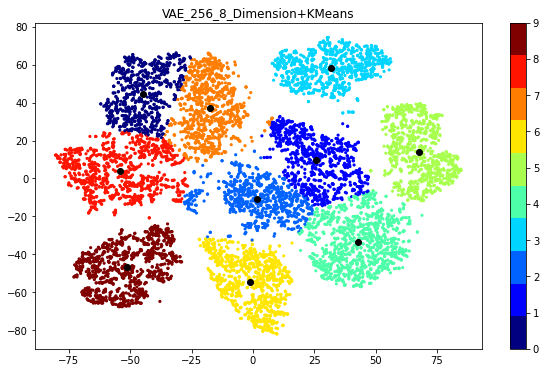

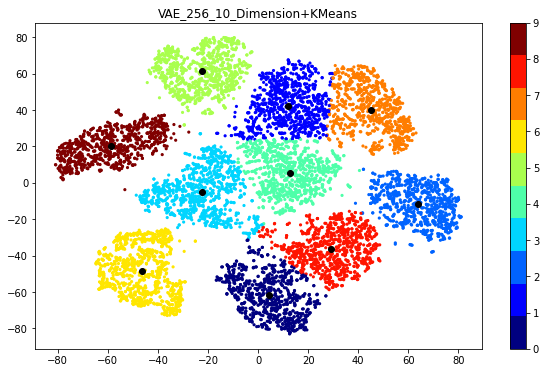

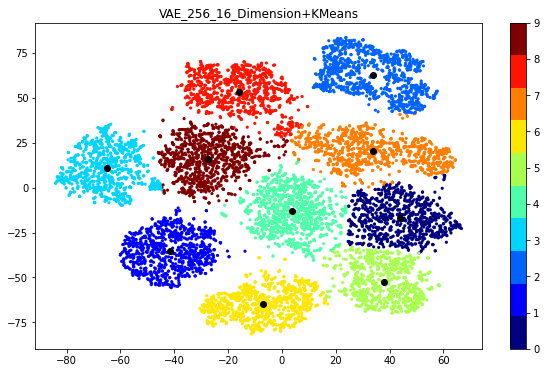

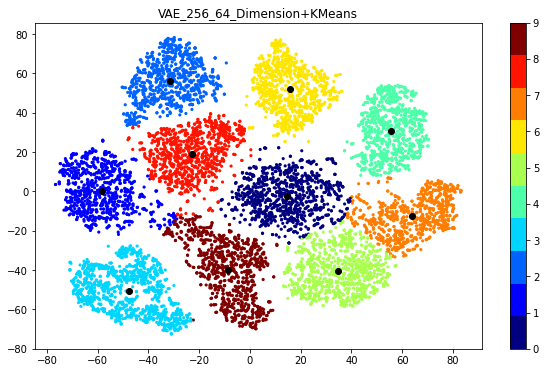

In [18]:
def kmeans_visualization(kmeans, features, name):
    predictions = kmeans.predict(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, 0], features[:, 1], c=predictions, marker='o',
                edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[:, 1], c='black')
    plt.title(name)
    plt.savefig('./figures/'+name+'.png')
    plt.show()

kmeans_visualization(kmeans8, tsne_features8, 'VAE_256_8_Dimension+KMeans')
kmeans_visualization(kmeans10, tsne_features10, 'VAE_256_10_Dimension+KMeans')
kmeans_visualization(kmeans16, tsne_features16, 'VAE_256_16_Dimension+KMeans')
kmeans_visualization(kmeans64, tsne_features64, 'VAE_256_64_Dimension+KMeans')

## VAE + GMM

### Model Predictions

In [19]:
def gmm_prediction(features, true_labels):
    gmm = mixture.GaussianMixture(n_components=10).fit(features)
    y_gmm = gmm.predict(features)
    acc = completeness_score(true_labels, y_gmm)
    nmi = normalized_mutual_info_score(true_labels, y_gmm)
    print('acc =', acc)
    print('nmi =', nmi)
    print('='*40)
    return gmm, acc, nmi

gmm8, gmm_acc8, gmm_nmi8 = gmm_prediction(tsne_features8, true_labels)
gmm10, gmm_acc10, gmm_nmi10 = gmm_prediction(tsne_features10, true_labels)
gmm16, gmm_acc16, gmm_nmi16 = gmm_prediction(tsne_features16, true_labels)
gmm64, gmm_acc64, gmm_nmi64 = gmm_prediction(tsne_features64, true_labels)

acc = 0.8203878181990929
nmi = 0.8196597343690661
acc = 0.8282190981464385
nmi = 0.8273536602642801
acc = 0.8454385589238724
nmi = 0.8360139929421786
acc = 0.8761673827069776
nmi = 0.8755255329448756


### Visualization

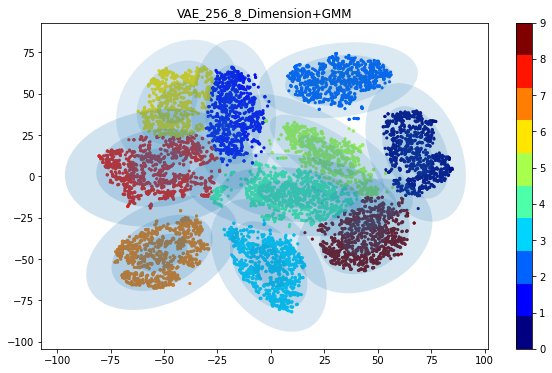

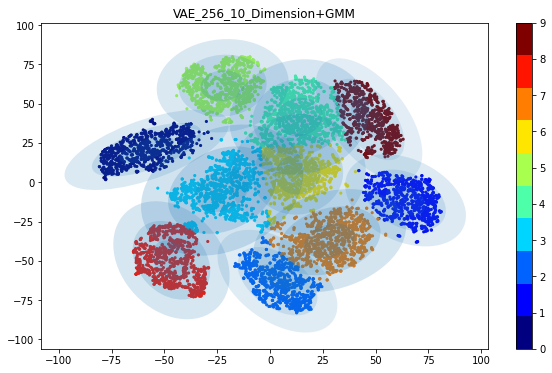

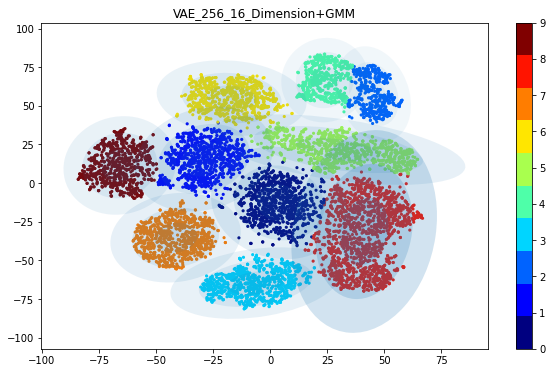

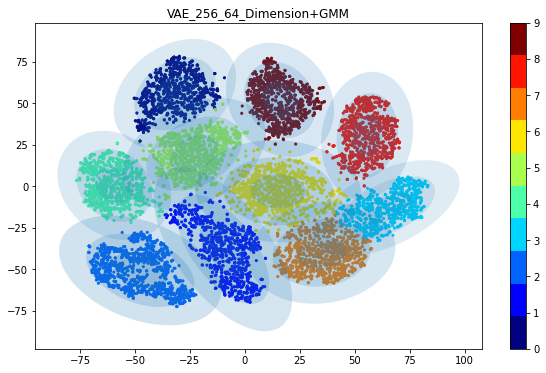

In [20]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))

def gmm_visualization(gmm, features, name):
    y_gmm = gmm.predict(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, 0], features[:, 1], c=y_gmm, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title(name)
    plt.savefig('./figures/'+name+'.png')
    plt.show()

gmm_visualization(gmm8, tsne_features8, 'VAE_256_8_Dimension+GMM')
gmm_visualization(gmm10, tsne_features10, 'VAE_256_10_Dimension+GMM')
gmm_visualization(gmm16, tsne_features16, 'VAE_256_16_Dimension+GMM')
gmm_visualization(gmm64, tsne_features64, 'VAE_256_64_Dimension+GMM')

## VAE + DPGMM

### Model Predictions

In [21]:
def dpgmm_prediction(features, true_labels):
    dpgmm = mixture.BayesianGaussianMixture(n_components=10).fit(features)
    y_dpgmm = dpgmm.predict(features)
    acc = completeness_score(true_labels, y_dpgmm)
    nmi = normalized_mutual_info_score(true_labels, y_dpgmm)
    print('acc =', acc)
    print('nmi =', nmi)
    print('='*40)
    return dpgmm, acc, nmi

dpgmm8, dpgmm_acc8, dpgmm_nmi8 = dpgmm_prediction(tsne_features8, true_labels)
dpgmm10, dpgmm_acc10, dpgmm_nmi10 = dpgmm_prediction(tsne_features10, true_labels)
dpgmm16, dpgmm_acc16, dpgmm_nmi16 = dpgmm_prediction(tsne_features16, true_labels)
dpgmm64, dpgmm_acc64, dpgmm_nmi64 = dpgmm_prediction(tsne_features64, true_labels)

C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


acc = 0.8260411489447645
nmi = 0.8230748771662416


C:\Users\NataphopT\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\mixture\_base.py:277: ConvergenceWarning: Initialization 1 did not converge. Try different init parameters, or increase max_iter, tol or check for degenerate data.
  warnings.warn(


acc = 0.7939583641185942
nmi = 0.7820229168049007
acc = 0.8695382789805122
nmi = 0.8692145524607278
acc = 0.877051101382939
nmi = 0.8764777226823329


### Visualization

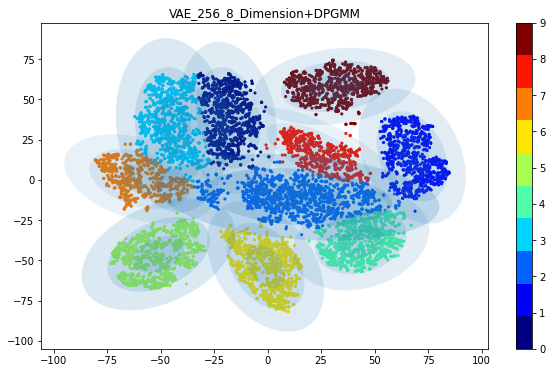

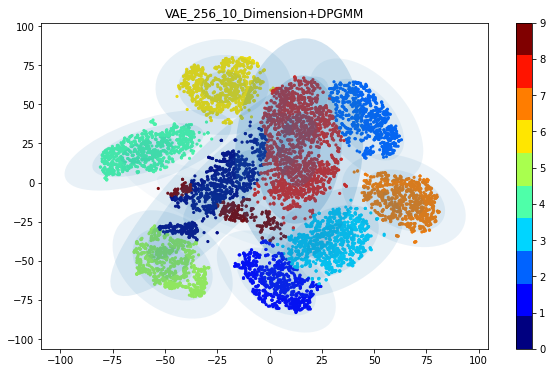

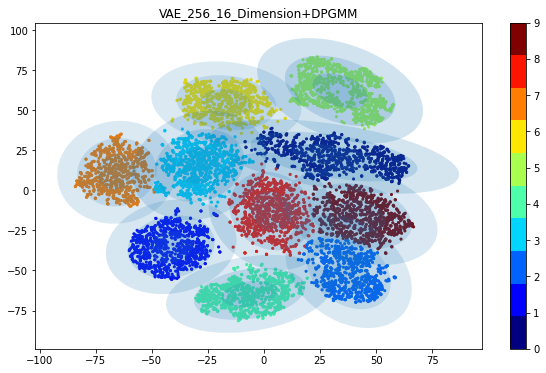

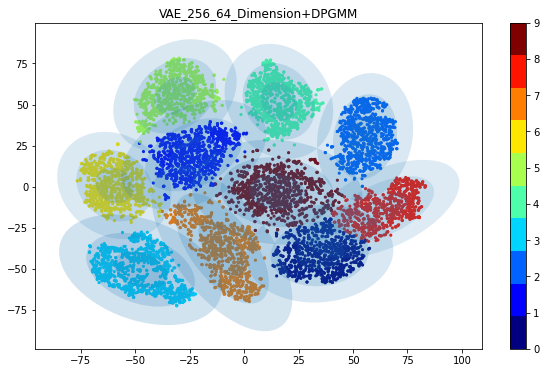

In [22]:
def dpgmm_visualization(dpgmm, features, name):
    y_dpgmm = dpgmm.predict(features)
    plt.figure(figsize=(10, 6))
    plt.scatter(features[:, 0], features[:, 1], c=y_dpgmm, marker='o',
            edgecolor='none', cmap=plt.cm.get_cmap('jet', 10), s = 10)
    plt.colorbar()
    w_factor = 0.2 / dpgmm.weights_.max()
    for pos, covar, w in zip(dpgmm.means_, dpgmm.covariances_, dpgmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title(name)
    plt.savefig('./figures/'+name+'.png')
    plt.show()

dpgmm_visualization(dpgmm8, tsne_features8, 'VAE_256_8_Dimension+DPGMM')
dpgmm_visualization(dpgmm10, tsne_features10, 'VAE_256_10_Dimension+DPGMM')
dpgmm_visualization(dpgmm16, tsne_features16, 'VAE_256_16_Dimension+DPGMM')
dpgmm_visualization(dpgmm64, tsne_features64, 'VAE_256_64_Dimension+DPGMM')